### Loading the original dataset

In [ ]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from scipy.stats import zscore
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy.stats import zscore
from scipy.special import boxcox1p
import warnings
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


In [3]:
# load the dataset
dataset_path = 'ai4i2020.csv'
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Data Preperation

In [6]:
# rename dataset columns
df.rename(columns = {'Air temperature [K]':'Air temperature',
                     'Process temperature [K]':'Process temperature',
                     'Rotational speed [rpm]':'Rotational speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool wear'},
          inplace = True)

In [7]:
# drop UDI and Product ID columns
df.drop(['Product ID', 'UDI'], axis=1, inplace = True)

In [8]:
df.info() # there are no null values, as it turns out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
 6   Machine failure      10000 non-null  int64  
 7   TWF                  10000 non-null  int64  
 8   HDF                  10000 non-null  int64  
 9   PWF                  10000 non-null  int64  
 10  OSF                  10000 non-null  int64  
 11  RNF                  10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [9]:
# overall descriptive information on numerical attributes
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Air temperature,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.0,0.0,0.0,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.0,0.0,0.0,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.0,0.0,0.0,1.0
OSF,10000.0,0.00980,0.098514,0.0,0.0,0.0,0.0,1.0


In [10]:
# overall descriptive information on categorical attributes
df_categorical = df.select_dtypes(include=[np.object_])
df_categorical.describe().transpose()

,count,unique,top,freq
Type,10000,3,L,6000


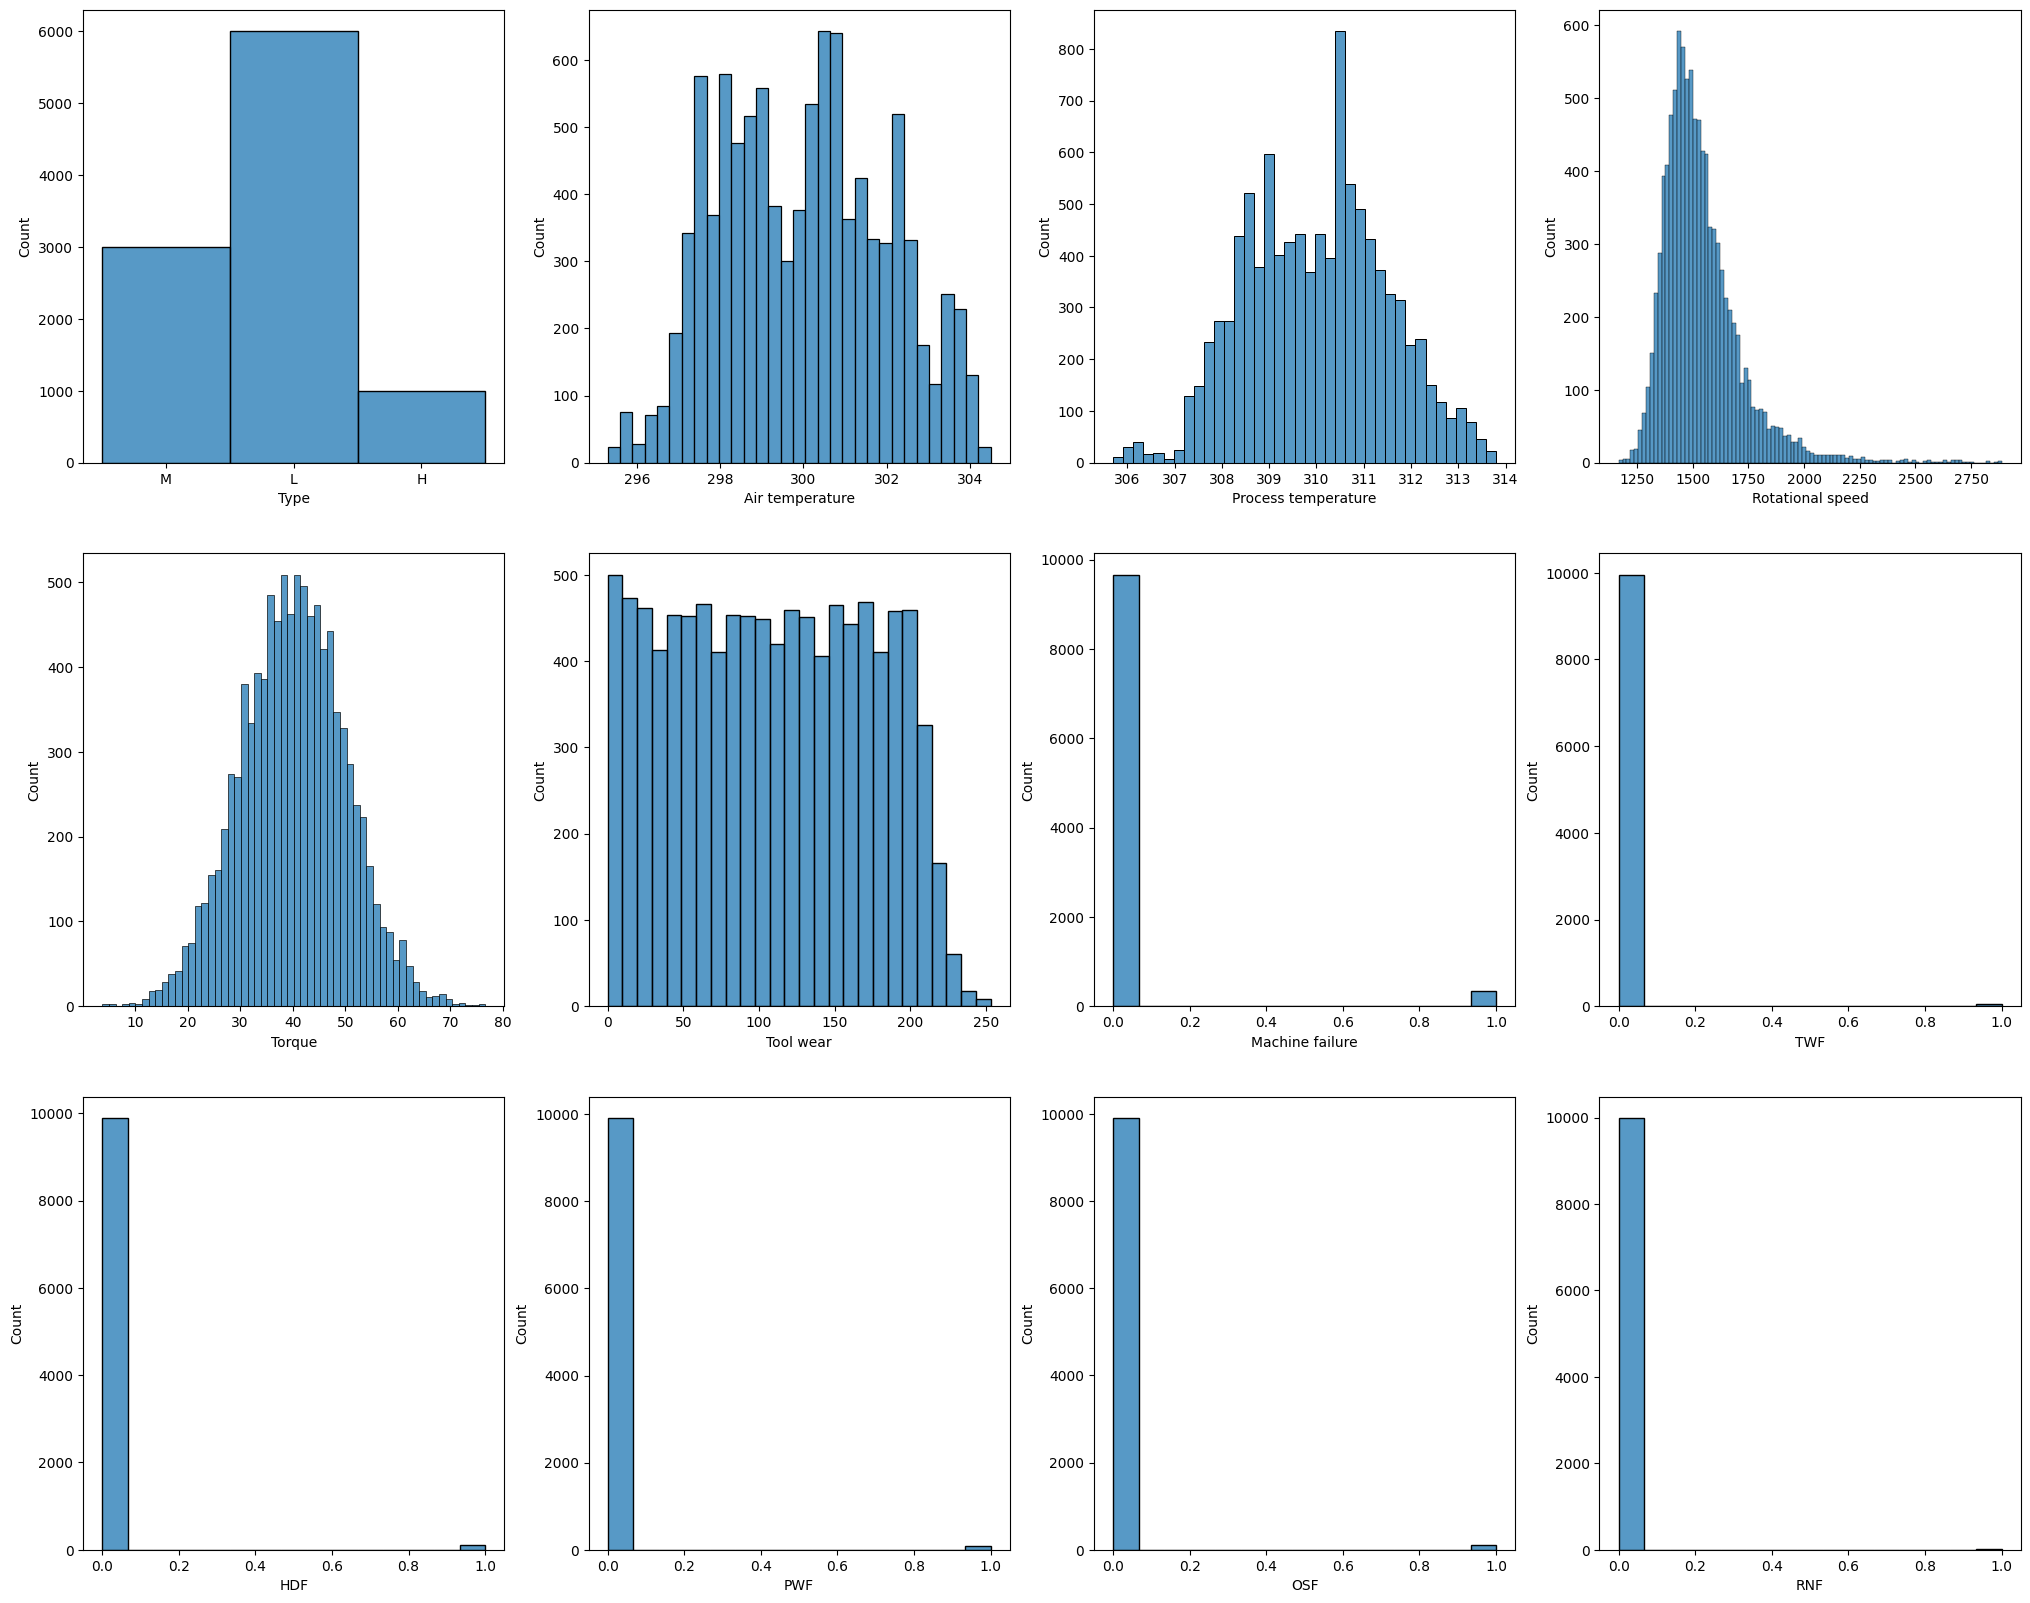

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(25, 20))

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=ax[i//4][i%4])

Text(0.5, 1.0, 'Number of failure types per record')

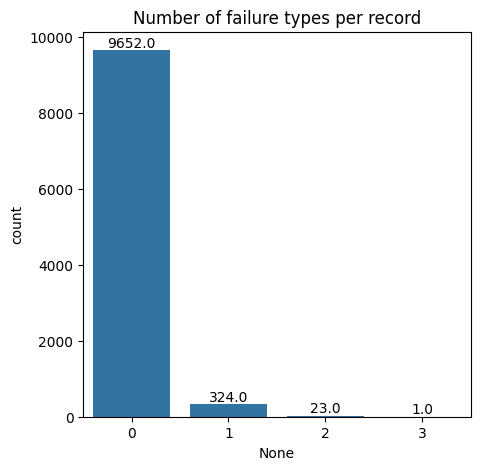

In [12]:
df_failures = df.loc[:, ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# Calculate the sum of the values in each row
rows_sum = df_failures.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=rows_sum, ax=ax)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
ax.set_title('Number of failure types per record')

In [13]:
df['Machine failure'] = 0

df.loc[df['TWF'] == 1, 'Machine failure'] = 1
df.loc[df['HDF'] == 1, 'Machine failure'] = 1
df.loc[df['PWF'] == 1, 'Machine failure'] = 1
df.loc[df['OSF'] == 1, 'Machine failure'] = 1
df.loc[df['RNF'] == 1, 'Machine failure'] = 1

# drop individual failure types
df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
 6   Machine failure      10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


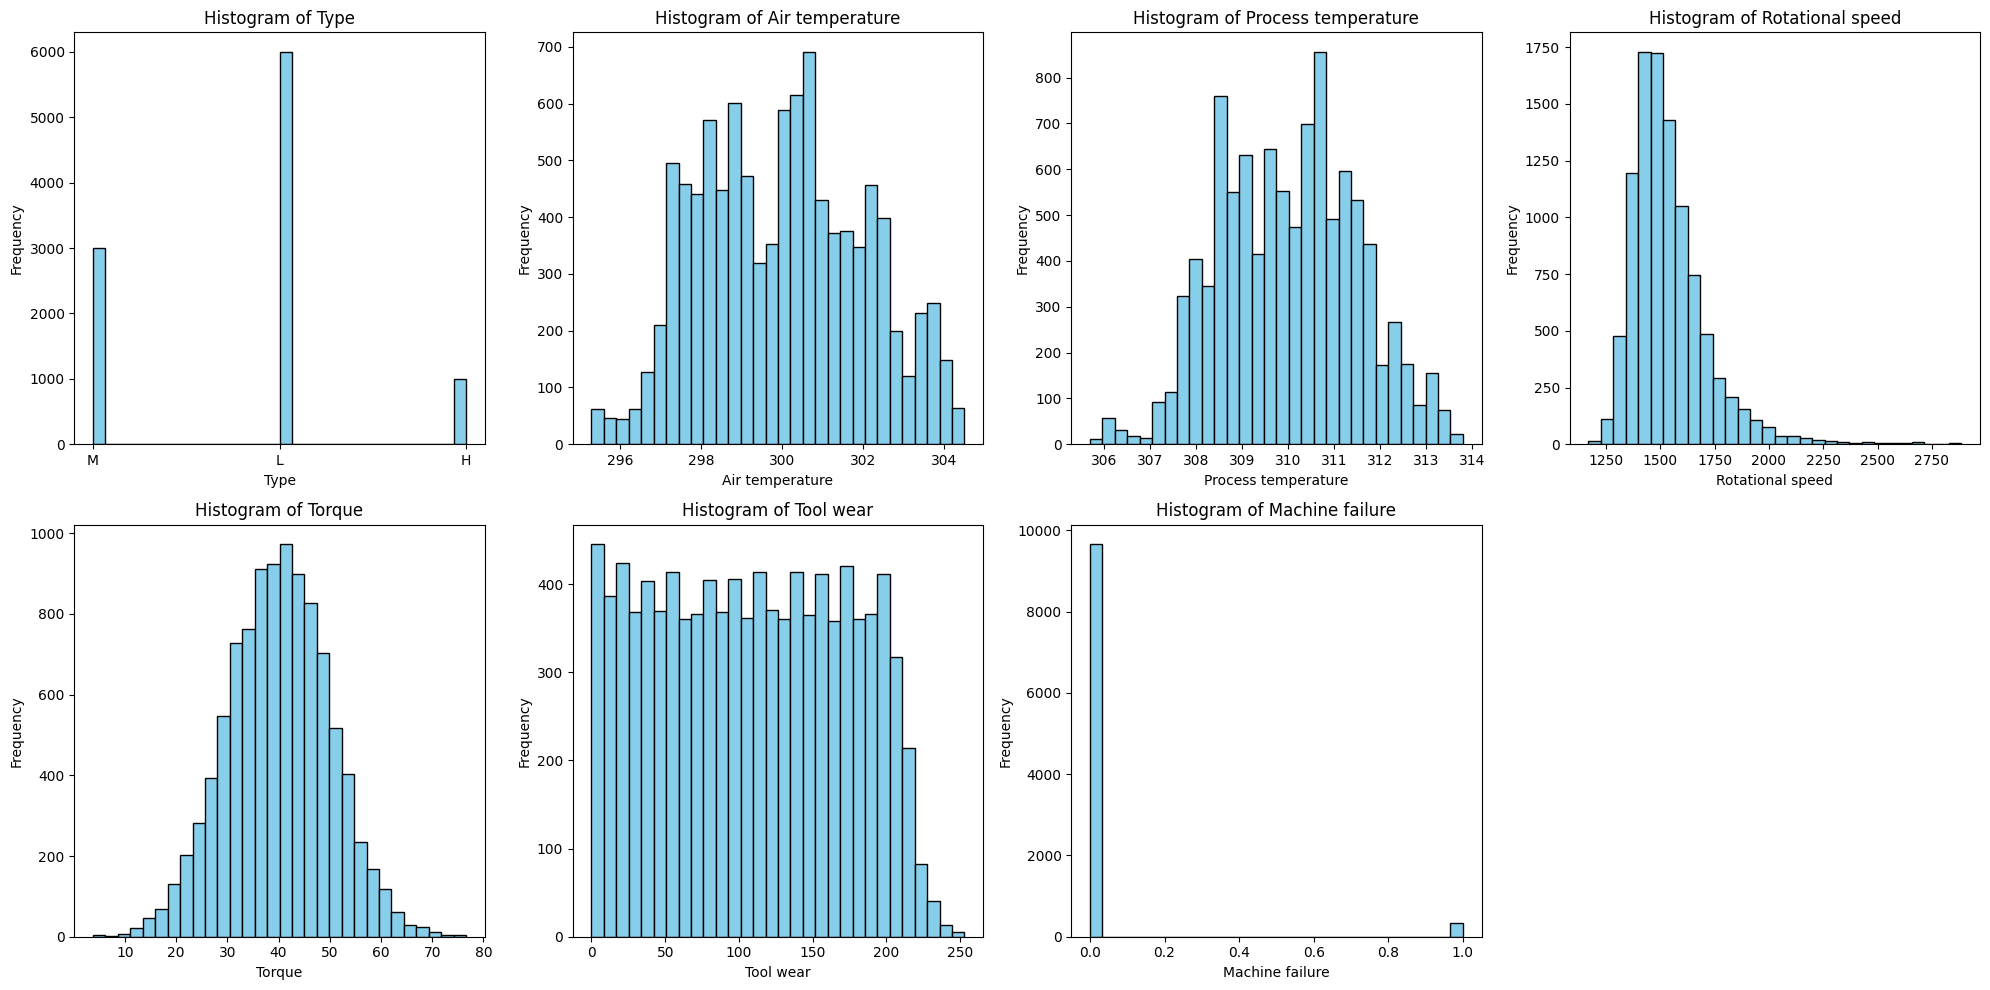

In [15]:
# List of all feature names to iterate over
all_features = df.columns

# Set up the plot grid (adjust rows and cols based on the number of features)
n_features = len(all_features)
n_cols = 4  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Plot histogram for each feature
for i, feature in enumerate(all_features):
    ax = axes[i]
    ax.hist(df[feature].dropna(), bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

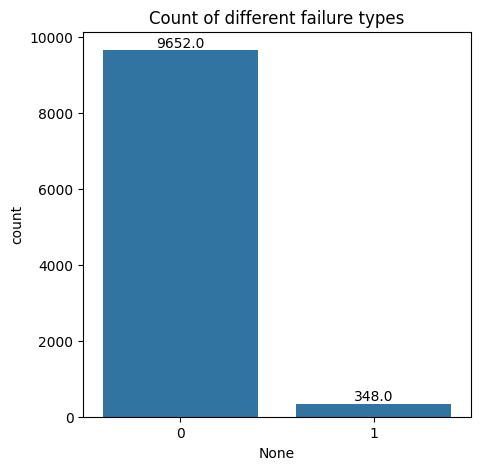

In [16]:
failure_types = df.loc[:, ['Machine failure']]

rows_sum = failure_types.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=rows_sum, ax=ax)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
    ax.set_title('Count of different failure types')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
 6   Machine failure      10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


### Creating new features

- 'Power': 'Product of Rotational speed and Torque, representing the power output of the machine.',

- 'temperature_differential': 'Difference between Process temperature and Air temperature, indicating the temperature change during the process.',

- 'power_speed_ratio': 'Ratio of Power to Rotational speed, representing the efficiency of power usage relative to speed.',

- 'thermal_stress': 'Product of temperature_differential and Power, representing the thermal stress on the machine.',

- 'operational_stress': 'Product of Torque and Tool wear, representing the operational stress on the machine.',

- 'efficiency_index': 'Ratio of Power to the product of Torque and Rotational speed, representing the overall efficiency of the machine.',

- 'wear_rate': 'Ratio of Tool wear to operational_stress, representing the rate of tool wear relative to operational stress.',

- 'temperature_stability': 'Rolling standard deviation of temperature_differential over a window of 3, representing the stability of temperature changes.',

- 'power_wear_interaction': 'Product of Power and Tool wear, representing the interaction effect between power output and tool wear.',

- 'speed_torque_efficiency': 'Ratio of Rotational speed to Torque, representing the efficiency of speed relative to torque.',

- 'wear_rate': 'Product of Tool wear and the ratio of Rotational speed to 1000, representing the wear rate adjusted for speed.'

In [18]:
df['Power'] = df[['Rotational speed', 'Torque']].product(axis=1)
# Basic engineering
df['temperature_differential'] = df['Process temperature'] - df['Air temperature']
df['power_speed_ratio'] = df['Power'] / (df['Rotational speed'] + 1)
                
# Advanced engineering
df['thermal_stress'] = df['temperature_differential'] * df['Power']
df['operational_stress'] = df['Torque'] * df['Tool wear']
df['efficiency_index'] = df['Power'] / (df['Torque'] * df['Rotational speed'] + 1)
df['temperature_stability'] = df['temperature_differential'].rolling(window=3).std()

# Interaction features
df['power_wear_interaction'] = df['Power'] * df['Tool wear']
df['speed_torque_efficiency'] = df['Rotational speed'] / (df['Torque'] + 1)
df['wear_rate'] = df['Tool wear'] * (df['Rotational speed']/1000)

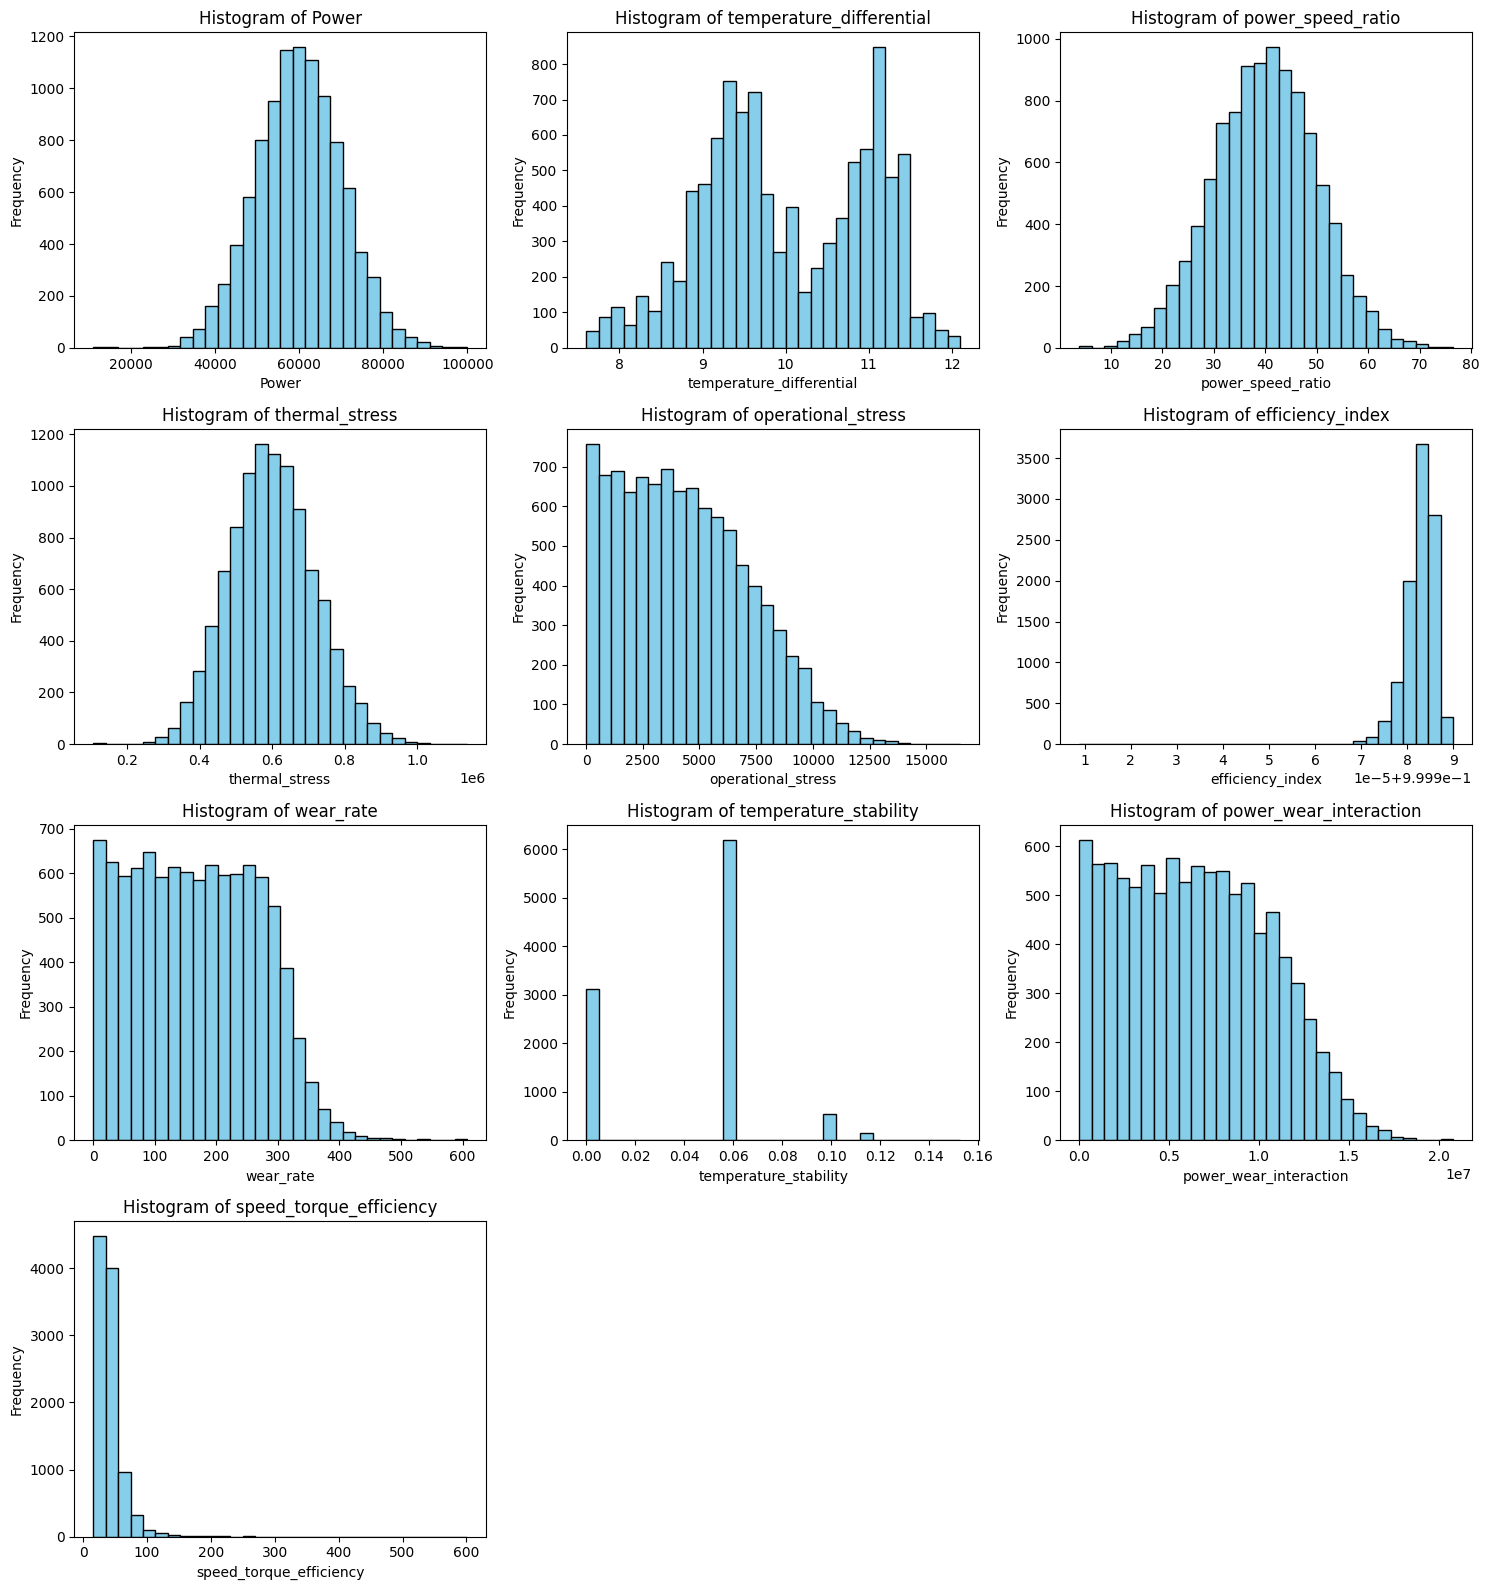

In [19]:
import matplotlib.pyplot as plt

# List of new feature names to iterate over
new_features = [
    'Power', 'temperature_differential', 'power_speed_ratio', 
    'thermal_stress', 'operational_stress', 'efficiency_index', 
    'wear_rate', 'temperature_stability', 'power_wear_interaction', 
    'speed_torque_efficiency'
]

# Set up the plot grid (adjust rows and cols based on the number of features)
n_features = len(new_features)
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Plot histogram for each feature
for i, feature in enumerate(new_features):
    ax = axes[i]
    ax.hist(df[feature].dropna(), bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### data type conversion

In [20]:
# convert Type attribute into numbers, such that L = 0, M = 1, and H = 2
df['Type'] = df['Type'].replace({'L': 0, 'M': 1, 'H': 2})

/tmp/ipykernel_961/481295868.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Type'] = df['Type'].replace({'L': 0, 'M': 1, 'H': 2})


In [21]:
# turn all columns into float for easier processing later
for column in df.columns:
    df[column] = df[column].astype(float)

In [22]:
# view columns data types
df.dtypes

Type                        float64
Air temperature             float64
Process temperature         float64
Rotational speed            float64
Torque                      float64
Tool wear                   float64
Machine failure             float64
Power                       float64
temperature_differential    float64
power_speed_ratio           float64
thermal_stress              float64
operational_stress          float64
efficiency_index            float64
temperature_stability       float64
power_wear_interaction      float64
speed_torque_efficiency     float64
wear_rate                   float64
dtype: object

### Handling Outliers

In [23]:
# List of columns to exclude from normalization and winsorization
excluded_columns = ['Type', 'Machine failure']

1. Domain-Specific Rules (Phase 1):


Applies engineering constraints for operating parameters
Enforces physical relationships between variables
Sets realistic limits for measurements and rates of change


2. Statistical Methods (Phase 2):


Uses distribution-aware techniques (Z-score, IQR)
Adapts to normal and non-normal distributions
Implements temporal consistency checks


3. Multivariate Detection (Phase 3):


Employs ensemble of multiple detectors
Uses weighted voting system
Preserves important feature relationships

- Key Features:

Preserves categorical variables ('Type') and target variable ('Machine failure')
Provides detailed cleaning statistics
Handles both normal and non-normal distributions
Maintains data integrity through physics-based rules

In [ ]:
def handle_outliers(df, excluded_columns=['Machine failure']):
    """
    Handle outliers with proper NaN handling
    """
    # Create copy of dataframe
    df_clean = df.copy()
    outlier_flags = pd.DataFrame(index=df_clean.index)
    
    # Get features for outlier detection
    features = [col for col in df.columns if col not in excluded_columns]
    
    # Handle NaN values first
    imputer = SimpleImputer(strategy='median')
    df_clean[features] = imputer.fit_transform(df_clean[features])
    
    # Step 1: Adaptive IQR Method with Winsorization
    for column in features:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        skewness = abs(df_clean[column].skew())
        iqr_multiplier = 1.5 + (0.5 * (skewness > 1))
        
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        outlier_flags[f'{column}_iqr_outlier'] = (
            (df_clean[column] < lower_bound) | 
            (df_clean[column] > upper_bound)
        ).astype(int)
        
        df_clean[column] = df_clean[column].clip(lower_bound, upper_bound)
    
    # Step 2: Feature-specific treatment
    feature_specific_rules = {
        'Torque': {'multiplier': 2.0, 'winsor_quantile': 0.02},
        'Tool wear': {'multiplier': 2.0, 'winsor_quantile': 0.02},
        'Rotational speed': {'multiplier': 1.8, 'winsor_quantile': 0.01},
        'Power': {'multiplier': 1.8, 'winsor_quantile': 0.01}
    }
    
    for feature, rules in feature_specific_rules.items():
        if feature in features:
            Q1 = df_clean[feature].quantile(0.25)
            Q3 = df_clean[feature].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - rules['multiplier'] * IQR
            upper_bound = Q3 + rules['multiplier'] * IQR
            
            outlier_flags[f'{feature}_specific_outlier'] = (
                (df_clean[feature] < lower_bound) | 
                (df_clean[feature] > upper_bound)
            ).astype(int)
            
            df_clean[feature] = df_clean[feature].clip(lower_bound, upper_bound)
    
    # Step 3: Multi-variate Outlier Detection
    X = df_clean[features].copy()
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Isolation Forest
    try:
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        isolation_labels = iso_forest.fit_predict(X_scaled)
        outlier_flags['isolation_forest_outlier'] = (isolation_labels == -1).astype(int)
    except Exception as e:
        print(f"Isolation Forest failed: {str(e)}")
        outlier_flags['isolation_forest_outlier'] = 0
    
    # Local Outlier Factor
    try:
        lof = LocalOutlierFactor(contamination=0.05, n_neighbors=20)
        lof_labels = lof.fit_predict(X_scaled)
        outlier_flags['lof_outlier'] = (lof_labels == -1).astype(int)
    except Exception as e:
        print(f"LOF failed: {str(e)}")
        outlier_flags['lof_outlier'] = 0
    
    # DBSCAN
    try:
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        outlier_flags['dbscan_outlier'] = (dbscan_labels == -1).astype(int)
    except Exception as e:
        print(f"DBSCAN failed: {str(e)}")
        outlier_flags['dbscan_outlier'] = 0
    
    # Robust Covariance
    try:
        robust_cov = EllipticEnvelope(contamination=0.05, random_state=42)
        robust_cov_labels = robust_cov.fit_predict(X_scaled)
        outlier_flags['robust_cov_outlier'] = (robust_cov_labels == -1).astype(int)
    except Exception as e:
        print(f"Robust Covariance failed: {str(e)}")
        outlier_flags['robust_cov_outlier'] = 0
    
    # Calculate consensus score
    outlier_flags['consensus_score'] = outlier_flags.mean(axis=1)
    consensus_threshold = 0.4
    final_mask = outlier_flags['consensus_score'] <= consensus_threshold
    
    # Apply final mask
    df_clean = df_clean[final_mask].copy()
    
    # Print summary
    print("\nOutlier Detection Summary:")
    print("-" * 50)
    print(f"Original dataset size: {len(df)}")
    print(f"Dataset size after outlier handling: {len(df_clean)}")
    print(f"Removed {len(df) - len(df_clean)} outliers ({((len(df) - len(df_clean))/len(df))*100:.2f}%)")
    
    for col in outlier_flags.columns:
        if col != 'consensus_score':
            outlier_count = outlier_flags[col].sum()
            print(f"{col}: {outlier_count} outliers ({(outlier_count/len(df)*100):.2f}%)")
    
    # Save outlier flags
    outlier_flags.to_csv('outlier_flags.csv')
    
    return df_clean

# Usage
df_clean = handle_outliers(df)

/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-135.816064705976800 > -136.907980248378692). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-136.049904032568861 > -137.095161725963351). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-135.714539437290597 > -138.246115020462241). You may want to try with a hig


Outlier Detection Summary:
--------------------------------------------------
Original dataset size: 10000
Dataset size after outlier handling: 9978
Removed 22 outliers (0.22%)
Type_iqr_outlier: 0 outliers (0.00%)
Air temperature_iqr_outlier: 0 outliers (0.00%)
Process temperature_iqr_outlier: 0 outliers (0.00%)
Rotational speed_iqr_outlier: 238 outliers (2.38%)
Torque_iqr_outlier: 69 outliers (0.69%)
Tool wear_iqr_outlier: 0 outliers (0.00%)
Power_iqr_outlier: 60 outliers (0.60%)
temperature_differential_iqr_outlier: 0 outliers (0.00%)
power_speed_ratio_iqr_outlier: 69 outliers (0.69%)
thermal_stress_iqr_outlier: 74 outliers (0.74%)
operational_stress_iqr_outlier: 20 outliers (0.20%)
efficiency_index_iqr_outlier: 129 outliers (1.29%)
temperature_stability_iqr_outlier: 11 outliers (0.11%)
power_wear_interaction_iqr_outlier: 3 outliers (0.03%)
speed_torque_efficiency_iqr_outlier: 401 outliers (4.01%)
wear_rate_iqr_outlier: 4 outliers (0.04%)
Torque_specific_outlier: 0 outliers (0.00%)


/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-135.711237983623619 > -136.915424108851624). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(


/tmp/ipykernel_961/3618587890.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5)


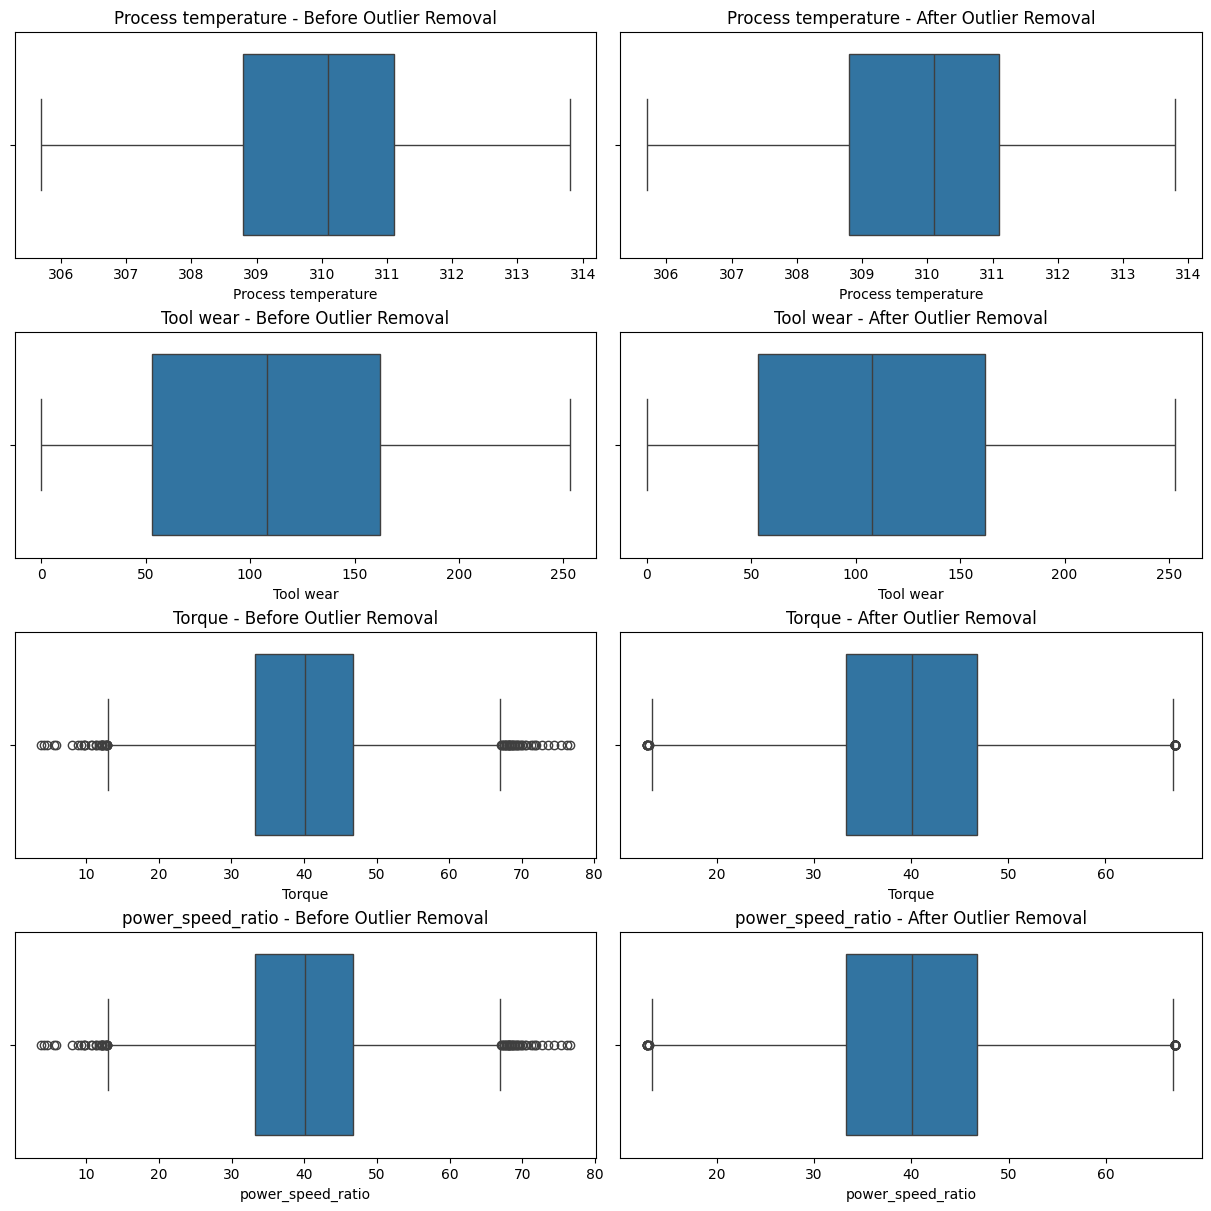

In [31]:
if excluded_columns is None:
        excluded_columns = []
    
# Filter out excluded columns
features = ['Process temperature', 'Tool wear', 'Torque', 'power_speed_ratio']

# Define the number of rows (one row per feature, two columns per feature)
num_rows = len(features)

# Create figure with a large vertical size to allow scrolling
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 3 * num_rows), constrained_layout=True)

for i, feature in enumerate(features):
    # Original data boxplot
    sns.boxplot(x=df[feature], ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} - Before Outlier Removal')
    
    # Cleaned data boxplot
    sns.boxplot(x=df_clean[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} - After Outlier Removal')

# Adjust spacing for clearer separation between rows
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

In [25]:
df= df_clean
df.shape # after removing the outliers

(9978, 17)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9978 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      9978 non-null   float64
 1   Air temperature           9978 non-null   float64
 2   Process temperature       9978 non-null   float64
 3   Rotational speed          9978 non-null   float64
 4   Torque                    9978 non-null   float64
 5   Tool wear                 9978 non-null   float64
 6   Machine failure           9978 non-null   float64
 7   Power                     9978 non-null   float64
 8   temperature_differential  9978 non-null   float64
 9   power_speed_ratio         9978 non-null   float64
 10  thermal_stress            9978 non-null   float64
 11  operational_stress        9978 non-null   float64
 12  efficiency_index          9978 non-null   float64
 13  temperature_stability     9978 non-null   float64
 14  power_wear_in

### Z-score normalization

Normalize the attributes using z-score

$z = \frac{x - \mu} {\sigma}$, $\mu:$ Mean, $σ:$ Standard deviation

In [ ]:
# Iterate over the columns in the dataframe
for col in df.columns:
      if col not in excluded_columns:
        # Normalize the values in the column
        df[col] = zscore(df[col])

### Enhanced Preprocessing Function:

STEP 1 Handles missing values ->
STEP 2 Encodes categorical variables ->
STEP 3 Scales numerical features ->
STEP 4 Checks for remaining features for skewness

In [ ]:
warnings.filterwarnings('ignore')

def enhanced_preprocessing(df, excluded_columns=['Type', 'Machine failure']):
    """
    Enhanced preprocessing pipeline with specific handling for different distributions
    """
    df_processed = df.copy()
    
    # Step 1: Check for missing values
    missing_stats = df_processed.isnull().sum()
    if missing_stats.sum() > 0:
        print("\nMissing Value Summary:")
        print(missing_stats[missing_stats > 0])
        
        # Add missing indicators if needed
        for col in df_processed.columns:
            if df_processed[col].isnull().sum() > 0:
                df_processed[f'{col}_missing'] = df_processed[col].isnull().astype(int)
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # Step 2: Handle data types and memory optimization
    # Convert Type to categorical and one-hot encode
    if 'Type' in df_processed.columns:
        df_processed['Type'] = df_processed['Type'].astype('category')
        type_dummies = pd.get_dummies(df_processed['Type'], prefix='Type')
        df_processed = pd.concat([df_processed, type_dummies], axis=1)
        df_processed.drop('Type', axis=1, inplace=True)
    
    # Memory optimization for numerical columns
    numerical_columns = df_processed.select_dtypes(include=['float64']).columns
    for col in numerical_columns:
        # Check if precision is critical based on unique values
        if df_processed[col].nunique() < 1000:
            df_processed[col] = df_processed[col].astype('float32')
    
    # Step 3: Feature-specific transformations
    # Initialize scalers
    minmax_scaler = MinMaxScaler()
    robust_scaler = RobustScaler()
    
    # Features with specific transformations
    transform_rules = {
        'temperature_differential': 'robust',  # Bimodal - use robust scaling
        'wear_rate': 'log',                   # Right-skewed - use log transform
        'power_speed_ratio': 'zscore',        # Normal - use z-score
        'efficiency_index': 'minmax',         # Concentrated - use minmax
        'Tool wear': 'log',                   # Typically right-skewed
        'Torque': 'robust',                   # May have outliers
        'Rotational speed': 'robust',         # May have outliers
        'Power': 'robust'                     # May have outliers
    }
    
    for col, transform in transform_rules.items():
        if col in df_processed.columns:
            if transform == 'log':
                # Add small constant to handle zeros
                min_val = df_processed[col].min()
                if min_val <= 0:
                    df_processed[col] = df_processed[col] - min_val + 1
                df_processed[col] = np.log1p(df_processed[col])
            
            elif transform == 'robust':
                df_processed[col] = robust_scaler.fit_transform(df_processed[[col]])
            
            elif transform == 'minmax':
                df_processed[col] = minmax_scaler.fit_transform(df_processed[[col]])
            
            elif transform == 'zscore':
                df_processed[col] = zscore(df_processed[col])
    
    # Step 4: Handle remaining numerical columns
    remaining_num_cols = [col for col in df_processed.select_dtypes(include=['float32', 'float64']).columns 
                         if col not in transform_rules.keys() and col not in excluded_columns]
    
    for col in remaining_num_cols:
        # Check skewness
        skewness = df_processed[col].skew()
        if abs(skewness) > 1:  # Highly skewed
            try:
                df_processed[col] = boxcox1p(df_processed[col], 0.25)
            except:
                df_processed[col] = zscore(df_processed[col])
        else:
            df_processed[col] = zscore(df_processed[col])
    
    # Print summary of transformations
    print("\nPreprocessing Summary:")
    print("-" * 50)
    print(f"Original memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"Processed memory usage: {df_processed.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"\nFeature transformations applied:")
    for col, transform in transform_rules.items():
        if col in df_processed.columns:
            print(f"- {col}: {transform}")
    
    return df_processed

df_preprocessed = enhanced_preprocessing(df)



Preprocessing Summary:
--------------------------------------------------
Original memory usage: 1.37 MB
Processed memory usage: 1.06 MB

Feature transformations applied:
- temperature_differential: robust
- wear_rate: log
- power_speed_ratio: zscore
- efficiency_index: minmax
- Tool wear: log
- Torque: robust
- Rotational speed: robust
- Power: robust


### plotting feature distributions

Transformation Analysis:
--------------------------------------------------

Feature: Air temperature
Metric            Original  Processed     Change
-----------------------------------------------
Mean                -0.000     -0.000
Std                  1.000      1.000
Skewness             0.115      0.115     -0.000
Kurtosis            -0.835     -0.835      0.000

Feature: Process temperature
Metric            Original  Processed     Change
-----------------------------------------------
Mean                 0.000      0.000
Std                  1.000      1.000
Skewness             0.015      0.015     -0.000
Kurtosis            -0.498     -0.498      0.000

Feature: Rotational speed
Metric            Original  Processed     Change
-----------------------------------------------
Mean                 0.000      0.150
Std                  1.000      0.814
Skewness             0.883      0.883     -0.000
Kurtosis             0.534      0.534      0.000

Feature: Torque
Metric     

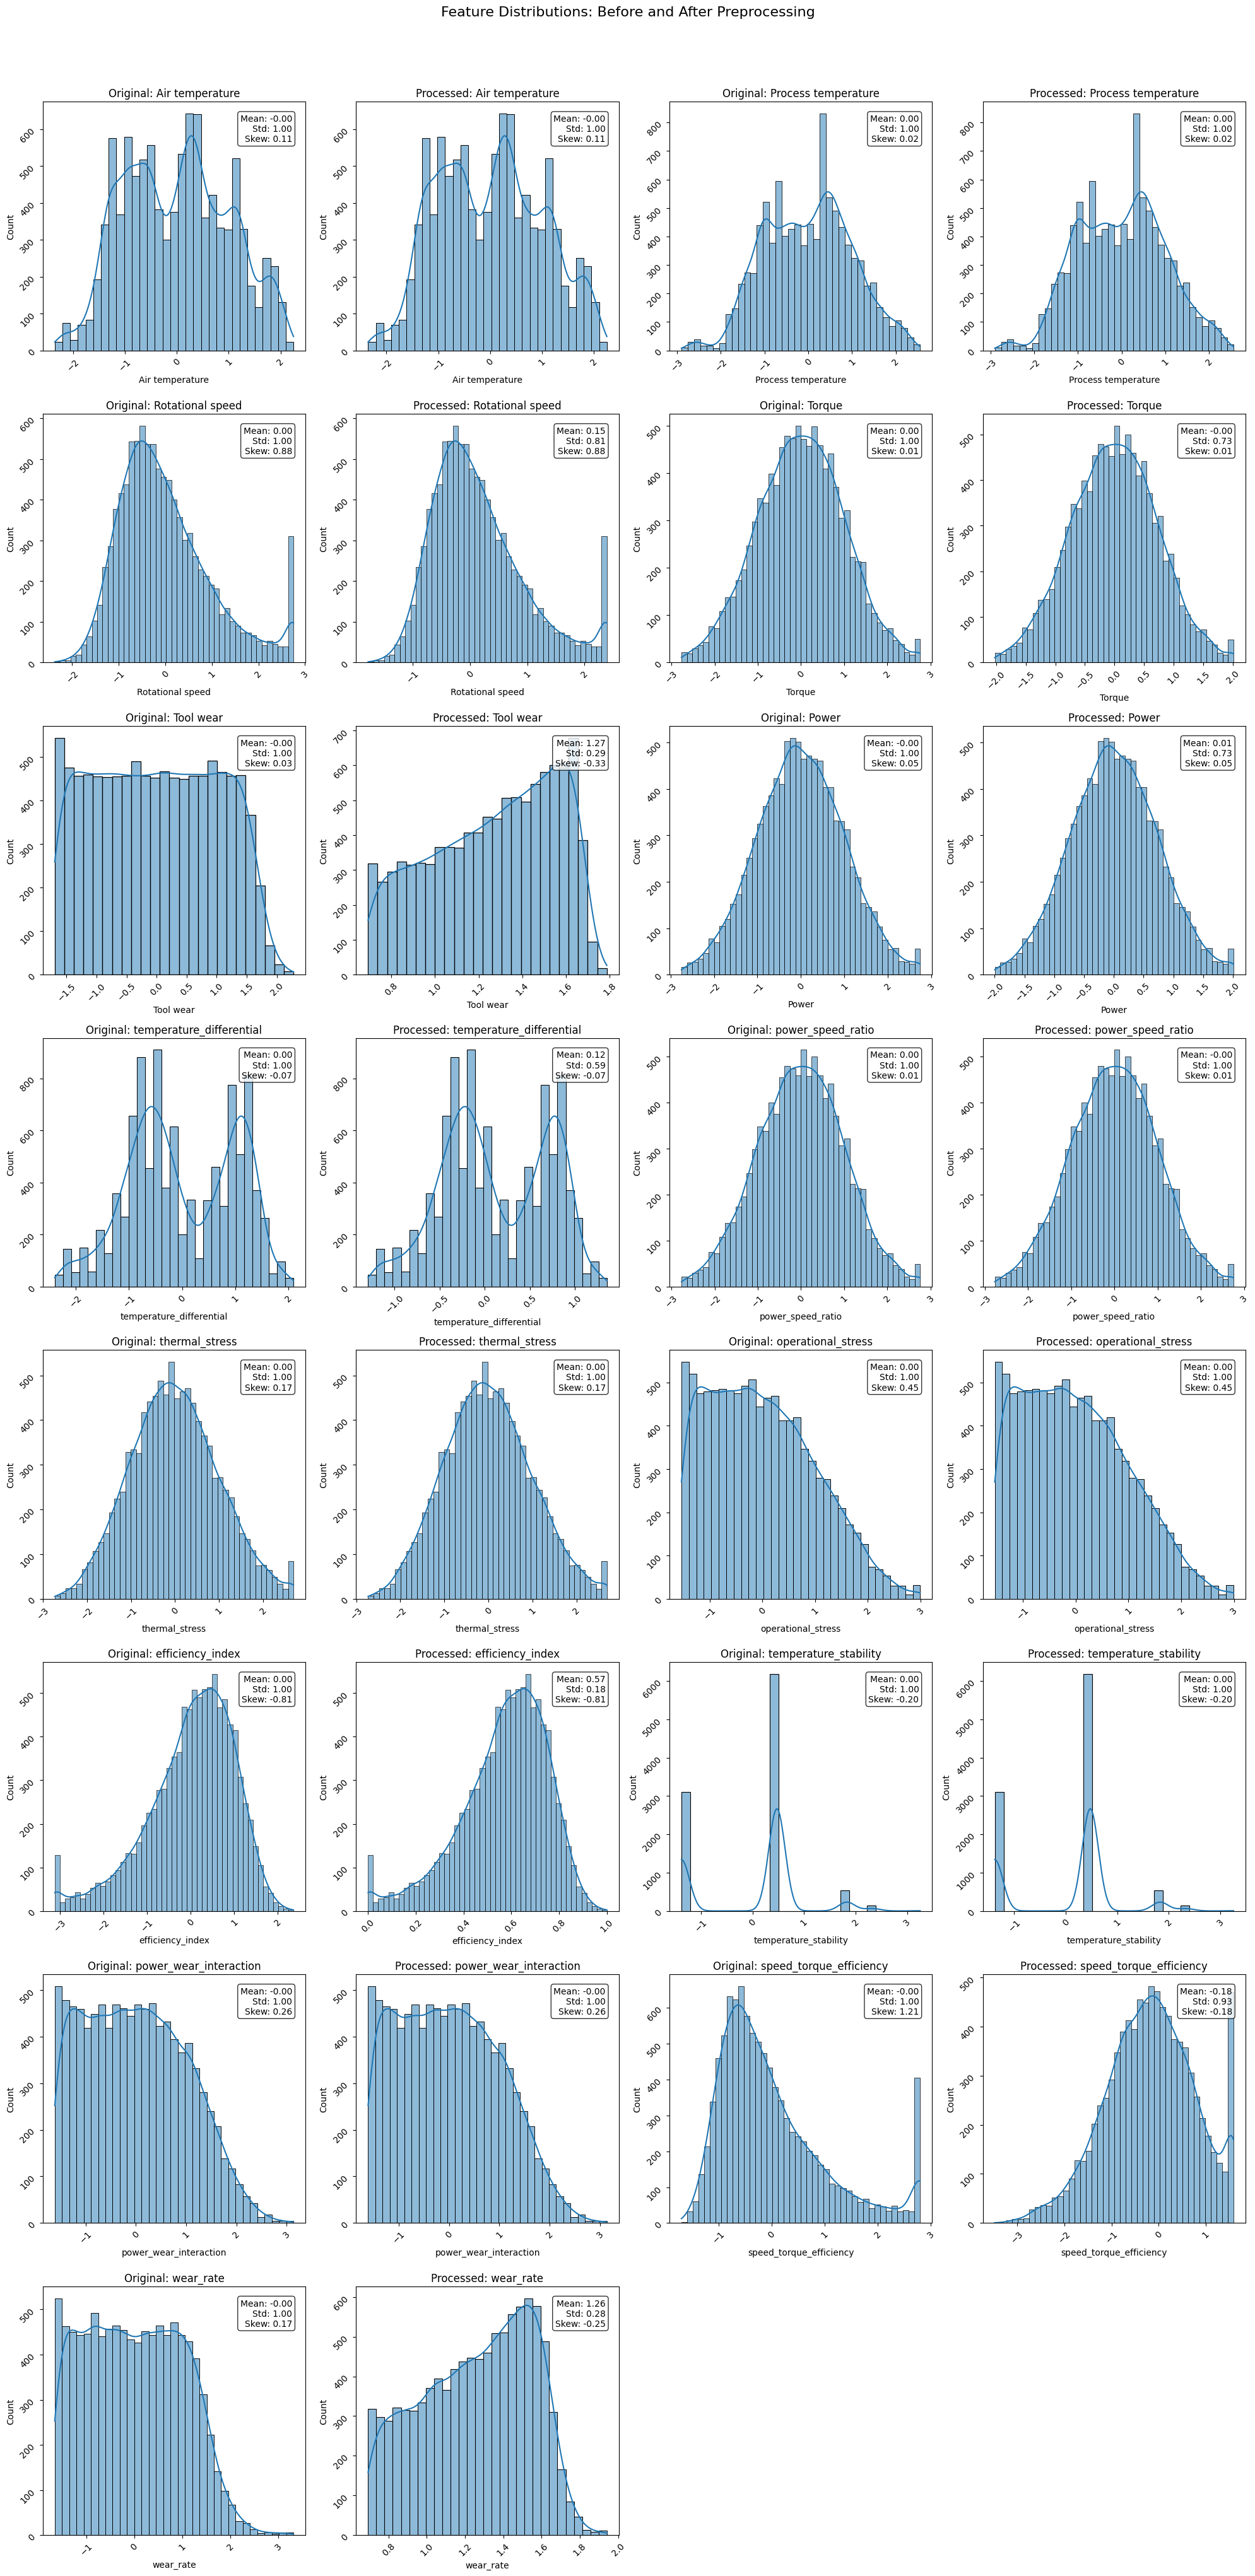

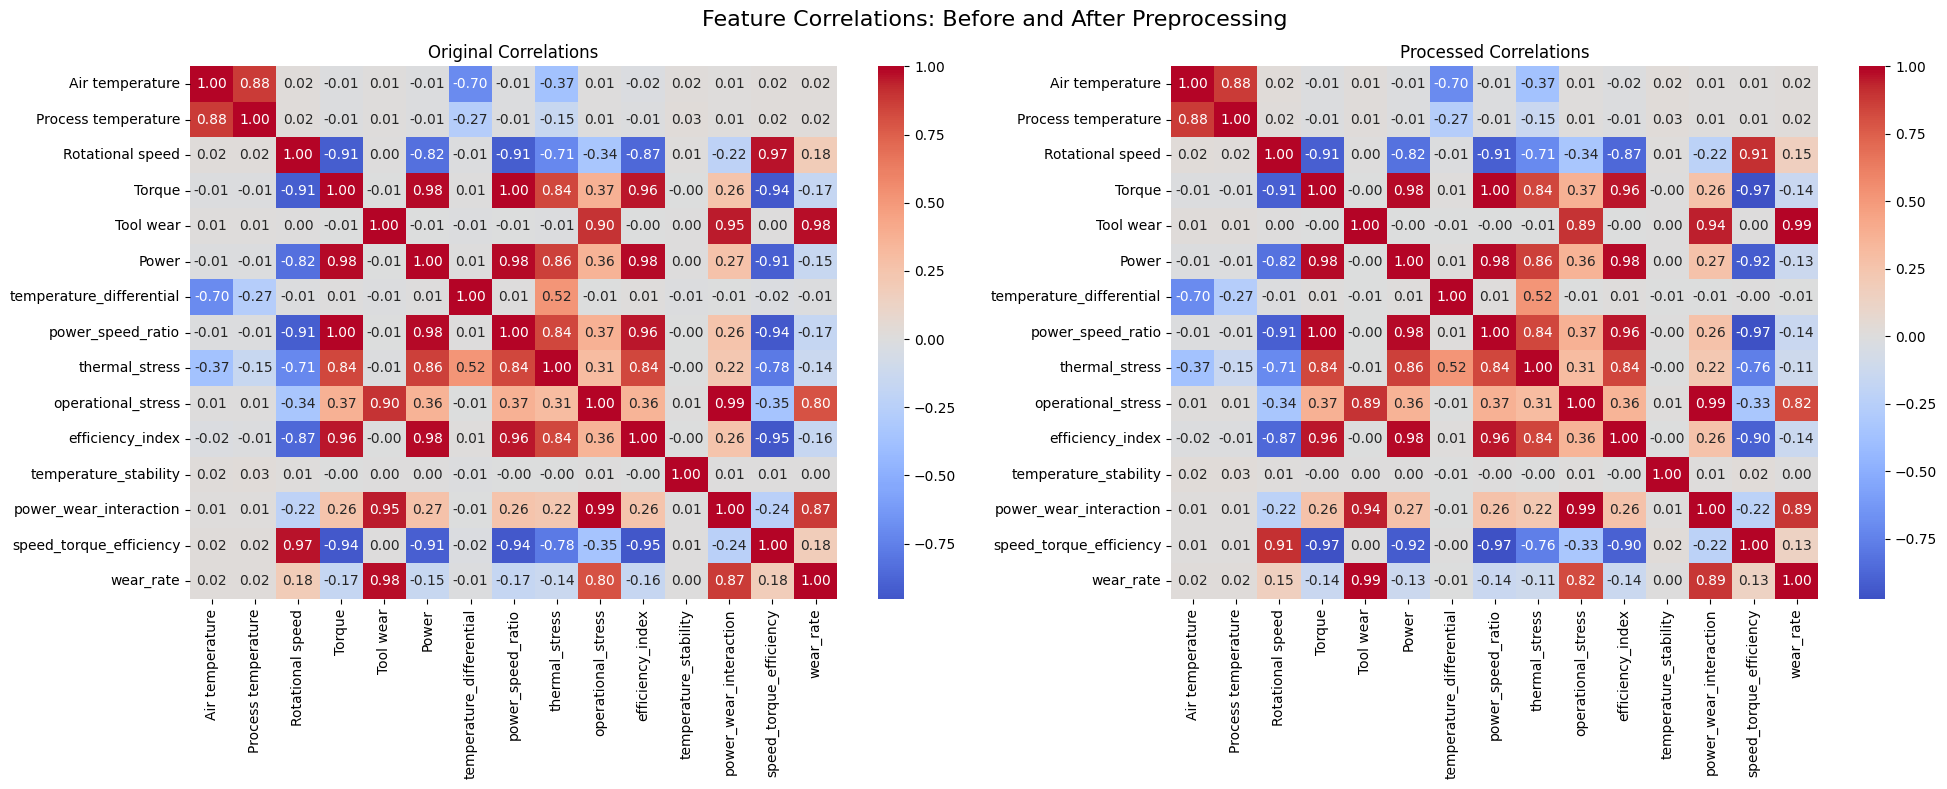

In [29]:
def plot_distributions(df_original, df_processed, excluded_columns=['Type', 'Machine failure']):
    """
    Compare distributions before and after preprocessing for all affected features
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get all numerical features that were processed
    features_to_plot = [col for col in df_processed.columns 
                       if col in df_original.columns 
                       and col not in excluded_columns
                       and df_original[col].dtype in ['float64', 'float32', 'int64']]
    
    # Calculate number of rows needed (2 features per row)
    n_rows = (len(features_to_plot) + 1) // 2
    
    # Create subplot grid
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
    fig.suptitle('Feature Distributions: Before and After Preprocessing', fontsize=16, y=1.02)
    
    # Flatten axes for easier indexing if there's only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(features_to_plot):
        row = idx // 2
        col = (idx % 2) * 2  # Multiply by 2 because each feature uses 2 columns
        
        # Original distribution
        sns.histplot(df_original[feature], ax=axes[row, col], kde=True)
        axes[row, col].set_title(f'Original: {feature}')
        axes[row, col].set_xlabel(feature)
        axes[row, col].tick_params(labelrotation=45)
        
        # Add basic statistics to the plot
        orig_stats = f'Mean: {df_original[feature].mean():.2f}\n'
        orig_stats += f'Std: {df_original[feature].std():.2f}\n'
        orig_stats += f'Skew: {df_original[feature].skew():.2f}'
        axes[row, col].text(0.95, 0.95, orig_stats,
                          transform=axes[row, col].transAxes,
                          verticalalignment='top',
                          horizontalalignment='right',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Processed distribution
        sns.histplot(df_processed[feature], ax=axes[row, col+1], kde=True)
        axes[row, col+1].set_title(f'Processed: {feature}')
        axes[row, col+1].set_xlabel(feature)
        axes[row, col+1].tick_params(labelrotation=45)
        
        # Add basic statistics to the plot
        proc_stats = f'Mean: {df_processed[feature].mean():.2f}\n'
        proc_stats += f'Std: {df_processed[feature].std():.2f}\n'
        proc_stats += f'Skew: {df_processed[feature].skew():.2f}'
        axes[row, col+1].text(0.95, 0.95, proc_stats,
                            transform=axes[row, col+1].transAxes,
                            verticalalignment='top',
                            horizontalalignment='right',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide any unused subplots
    for row in range(n_rows):
        for col in range(4):
            if row * 2 + col//2 >= len(features_to_plot):
                axes[row, col].set_visible(False)
    
    plt.tight_layout()
    return fig

def plot_correlation_changes(df_original, df_processed, excluded_columns=['Type', 'Machine failure']):
    """
    Compare correlation matrices before and after preprocessing
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get numerical columns for correlation
    num_cols = [col for col in df_processed.columns 
                if col in df_original.columns 
                and col not in excluded_columns
                and df_original[col].dtype in ['float64', 'float32', 'int64']]
    
    # Calculate correlation matrices
    corr_original = df_original[num_cols].corr()
    corr_processed = df_processed[num_cols].corr()
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Feature Correlations: Before and After Preprocessing', fontsize=16)
    
    # Plot original correlations
    sns.heatmap(corr_original, annot=True, cmap='coolwarm', center=0, ax=ax1, fmt='.2f')
    ax1.set_title('Original Correlations')
    
    # Plot processed correlations
    sns.heatmap(corr_processed, annot=True, cmap='coolwarm', center=0, ax=ax2, fmt='.2f')
    ax2.set_title('Processed Correlations')
    
    plt.tight_layout()
    return fig

def analyze_transformations(df_original, df_processed, excluded_columns=['Type', 'Machine failure']):
    """
    Print detailed analysis of the transformations
    """
    features = [col for col in df_processed.columns 
                if col in df_original.columns 
                and col not in excluded_columns
                and df_original[col].dtype in ['float64', 'float32', 'int64']]
    
    print("Transformation Analysis:")
    print("-" * 50)
    
    for feature in features:
        orig_skew = df_original[feature].skew()
        proc_skew = df_processed[feature].skew()
        orig_kurt = df_original[feature].kurtosis()
        proc_kurt = df_processed[feature].kurtosis()
        
        print(f"\nFeature: {feature}")
        print(f"{'Metric':<15} {'Original':>10} {'Processed':>10} {'Change':>10}")
        print("-" * 47)
        print(f"{'Mean':<15} {df_original[feature].mean():>10.3f} {df_processed[feature].mean():>10.3f}")
        print(f"{'Std':<15} {df_original[feature].std():>10.3f} {df_processed[feature].std():>10.3f}")
        print(f"{'Skewness':<15} {orig_skew:>10.3f} {proc_skew:>10.3f} {proc_skew-orig_skew:>10.3f}")
        print(f"{'Kurtosis':<15} {orig_kurt:>10.3f} {proc_kurt:>10.3f} {proc_kurt-orig_kurt:>10.3f}")

# Example usage:
fig1 = plot_distributions(df, df_preprocessed)
fig2 = plot_correlation_changes(df, df_preprocessed)
analyze_transformations(df, df_preprocessed)

### solving class imbalancing

class imbalance

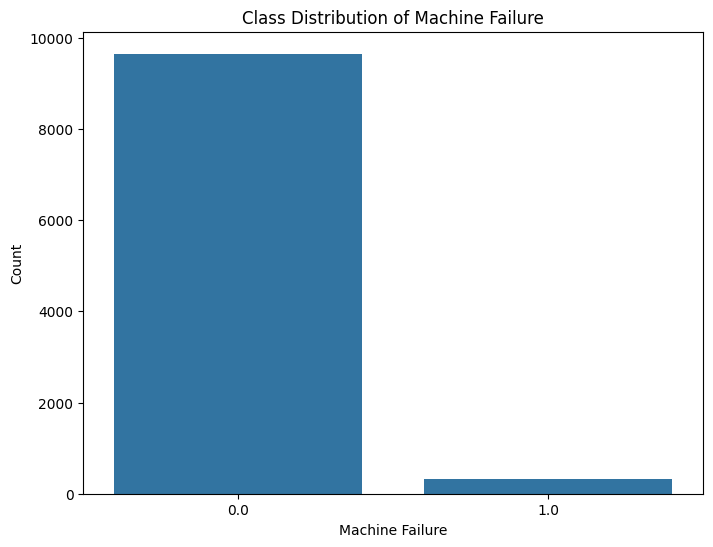

In [32]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the class distribution of 'Machine failure'
plt.figure(figsize=(8, 6))
sns.countplot(x='Machine failure', data=df)
plt.title('Class Distribution of Machine Failure')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.show()

Original class distribution: Counter({0.0: 8829, 1.0: 139})
Resampled class distribution: Counter({0.0: 8829, 1.0: 8829})
Original class distribution: Counter({0.0: 8829, 1.0: 139})
Resampled class distribution: Counter({1.0: 8846, 0.0: 8829})
Original class distribution: Counter({0.0: 8829, 1.0: 139})
Resampled class distribution: Counter({1.0: 8758, 0.0: 8174})
Original class distribution: Counter({0.0: 8829, 1.0: 139})
Resampled class distribution: Counter({0.0: 139, 1.0: 139})
Original class distribution: Counter({0.0: 8829, 1.0: 139})
Resampled class distribution: Counter({0.0: 5517, 1.0: 4414})


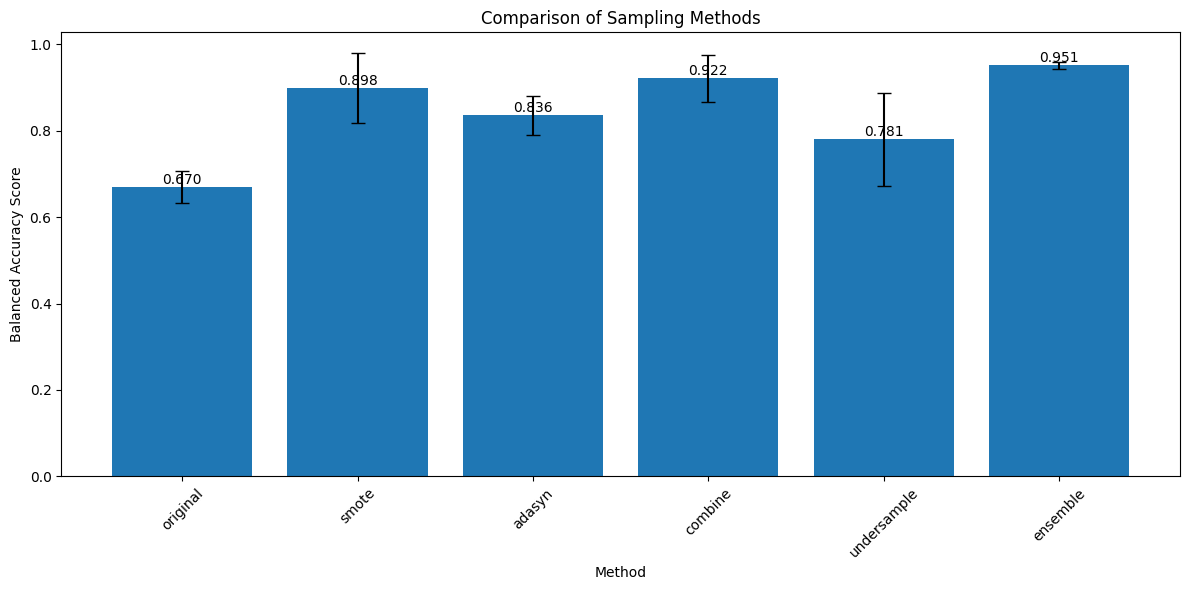

In [ ]:
def handle_imbalance(X, y, method='smote', random_state=42):
    """
    Handle class imbalance using various methods
    
    Parameters:
    -----------
    X : DataFrame or array-like
        Features
    y : Series or array-like
        Target variable
    method : str
        Method to use: 'smote', 'adasyn', 'combine', 'undersample', or 'ensemble'
    
    Returns:
    --------
    X_resampled, y_resampled
    """
    print("Original class distribution:", Counter(y))
    
    if method == 'smote':
        # SMOTE with safer parameters
        sampler = SMOTE(sampling_strategy='auto',
                       k_neighbors=5,
                       random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif method == 'adasyn':
        # ADASYN - Adaptive Synthetic Sampling
        sampler = ADASYN(sampling_strategy='auto',
                        n_neighbors=5,
                        random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif method == 'combine':
        # SMOTEENN - SMOTE with Edited Nearest Neighbors cleaning
        sampler = SMOTEENN(sampling_strategy='auto',
                          random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif method == 'undersample':
        # Undersampling the majority class
        sampler = RandomUnderSampler(sampling_strategy='auto',
                                   random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif method == 'ensemble':
        # Multiple sampling strategies combined
        # First SMOTE, then selective undersampling
        smote = SMOTE(sampling_strategy=0.5,  # Create minority samples to be 50% of majority
                     random_state=random_state)
        X_temp, y_temp = smote.fit_resample(X, y)
        
        under = RandomUnderSampler(sampling_strategy=0.8,  # Keep 80% of majority samples
                                 random_state=random_state)
        X_resampled, y_resampled = under.fit_resample(X_temp, y_temp)
    
    print("Resampled class distribution:", Counter(y_resampled))
    return X_resampled, y_resampled

def create_balanced_folds(X, y, n_splits=5, random_state=42):
    """
    Create stratified folds while handling imbalance
    """
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return skf.split(X, y)

def evaluate_sampling_methods(X, y, random_state=42):
    """
    Compare different sampling methods and their impact
    """
    
    methods = ['smote', 'adasyn', 'combine', 'undersample', 'ensemble']
    results = {}
    
    # Simple classifier for comparison
    clf = DecisionTreeClassifier(random_state=random_state)
    
    # Original data performance
    original_scores = cross_val_score(clf, X, y, cv=5, scoring='balanced_accuracy')
    results['original'] = {
        'mean_score': original_scores.mean(),
        'std_score': original_scores.std(),
        'class_distribution': Counter(y)
    }
    
    # Test each sampling method
    for method in methods:
        X_resampled, y_resampled = handle_imbalance(X, y, method=method)
        scores = cross_val_score(clf, X_resampled, y_resampled, cv=5, scoring='balanced_accuracy')
        
        results[method] = {
            'mean_score': scores.mean(),
            'std_score': scores.std(),
            'class_distribution': Counter(y_resampled)
        }
    
    return results

def plot_sampling_results(results):
    """
    Visualize the impact of different sampling methods
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Prepare data for plotting
    methods = list(results.keys())
    scores = [results[method]['mean_score'] for method in methods]
    errors = [results[method]['std_score'] for method in methods]
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(methods, scores, yerr=errors, capsize=5)
    plt.title('Comparison of Sampling Methods')
    plt.xlabel('Method')
    plt.ylabel('Balanced Accuracy Score')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()


# First, split your data into features and target
X = df_preprocessed.drop(['Machine failure'], axis=1)
y = df_preprocessed['Machine failure']

X.drop(['Type_0.0', 'Type_1.0', 'Type_2.0'], axis=1, inplace=True)
# Drop rows with missing values
X = X.dropna()
y = y[X.index]

# Evaluate different sampling methods
results = evaluate_sampling_methods(X, y)

# Plot the results
fig = plot_sampling_results(results)


In [34]:

# Choose the best method and apply it
X_resampled, y_resampled = handle_imbalance(X, y, method='ensemble')


Original class distribution: Counter({0.0: 8829, 1.0: 139})
Resampled class distribution: Counter({0.0: 5517, 1.0: 4414})


### saving it into a csv

In [35]:
# After resampling
# X_resampled, y_resampled = handle_imbalance(X, y, method='ensemble')

# Reconstruct the full dataframe with all features and target
# Convert to DataFrame if X_resampled is not already a DataFrame
if not isinstance(X_resampled, pd.DataFrame):
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Add the target variable back
df_resampled = X_resampled.copy()
df_resampled['Machine failure'] = y_resampled

# Save to CSV
df_resampled.to_csv('balanced_preprocessed_data.csv', index=False)

# Print shape information
print(f"Original data shape: {df.shape}")
print(f"Resampled data shape: {df_resampled.shape}")
print("\nClass distribution in resampled data:")
print(df_resampled['Machine failure'].value_counts(normalize=True))

Original data shape: (9978, 17)
Resampled data shape: (9931, 16)

Class distribution in resampled data:
Machine failure
0.0    0.555533
1.0    0.444467
Name: proportion, dtype: float64


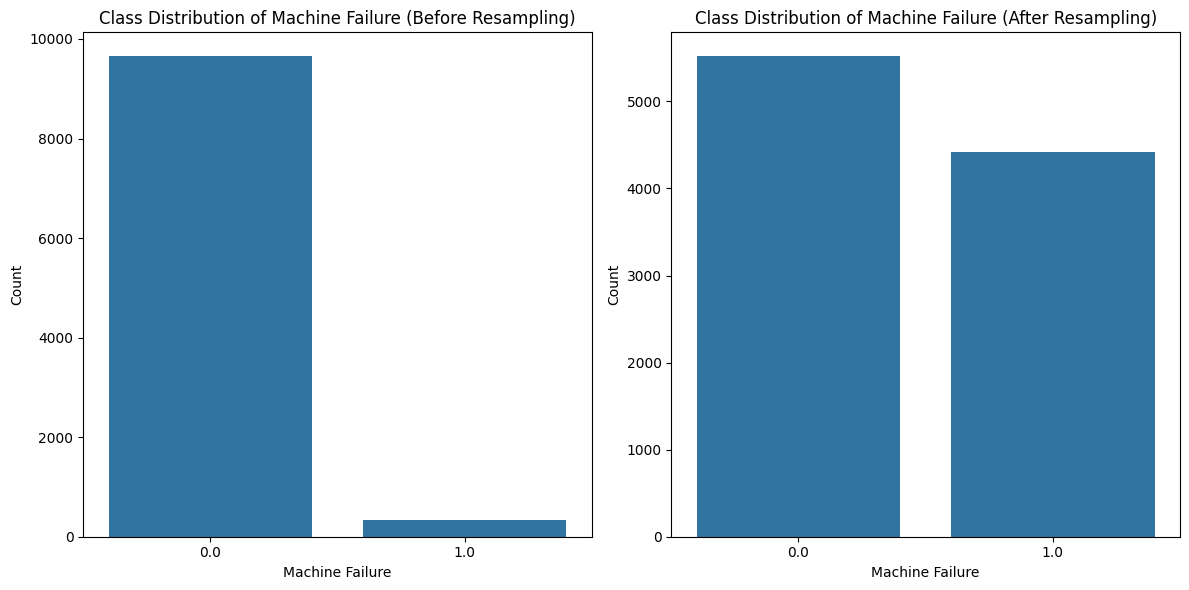

In [36]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the class distribution of 'Machine failure' before resampling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Machine failure', data=df)
plt.title('Class Distribution of Machine Failure (Before Resampling)')
plt.xlabel('Machine Failure')
plt.ylabel('Count')

# Plot the class distribution of 'Machine failure' after resampling
plt.subplot(1, 2, 2)
sns.countplot(x='Machine failure', data=df_resampled)
plt.title('Class Distribution of Machine Failure (After Resampling)')
plt.xlabel('Machine Failure')
plt.ylabel('Count')

plt.tight_layout()
plt.show()